In [1]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from config import api_key
from scipy.stats import linregress
import scipy.stats as st
import json
import requests

In [2]:
# Read the CSV file
df = pd.read_csv("Wrangled_df.csv",index_col = "Movie ID")
df.head()

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit
Movie ID,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09


# Expanding Genre into multiple binary columns

In [3]:
# Initialize an empty set to store all unique genres
unique_genres = set()

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and add each genre to the set
    movie_genres = [genre.strip() for genre in row['Genre'].split(',')]
    unique_genres.update(movie_genres)

# Convert the set of unique genres to a list
unique_genres = list(unique_genres)

# Iterate over the DataFrame rows again to create genre columns
for index, row in df.iterrows():
    # Split the 'Genre' column by commas and create a dictionary to store genre values
    movie_genres = {genre: 1 if genre.strip() in row['Genre'] else 0 for genre in unique_genres}
    
    # Update the DataFrame row with genre values
    for genre, value in movie_genres.items():
        df.at[index, genre] = value

# Print the updated DataFrame
df.head(5)

,Name,Year,Score,Genre,Budget,Revenue,Language,Profit,Family,Drama,...,Comedy,Adventure,Science Fiction,TV Movie,War,Western,Action,Crime,Documentary,Thriller
Movie ID,,,,,,,,,,,,,,,,,,,,,
0,the passion of the christ,2004,74.0,Drama,25000000.0,6.223136e+08,English,5.973136e+08,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,john wick: chapter 2,2017,73.0,"Action, Thriller, Crime",40000000.0,1.715399e+08,English,1.315399e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
2,john wick: chapter 3 - parabellum,2019,74.0,"Action, Thriller, Crime",55000000.0,3.267097e+08,English,2.717097e+08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
3,a bronx tale,1994,78.0,"Drama, Crime",10000000.0,1.728790e+07,English,7.287898e+06,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,avatar,2009,76.0,"Action, Adventure, Fantasy, Science Fiction",237000000.0,2.923706e+09,English,2.686706e+09,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Making a new Data Frame 

In [4]:
# Initialize lists to store data for pie chart
size = []
label = []
Genre = []
profit = []
budget = []
year = []
score =[]

# Iterate over the DataFrame rows
for index, row in df.iterrows():
    # Iterate over each genre column and check if it's 1
    for genre in unique_genres:
        if row[genre] == 1:
            # Append relevant data to lists
            label.append(row['Name'])
            size.append(row['Revenue'])  
            profit.append(row['Profit'])
            budget.append(row['Budget'])
            year.append(row['Year'])
            score.append(row['Score'])
            Genre.append(genre)
            
# Create a DataFrame from the lists
data = {'Name': label, 'Genre': Genre, 'Revenue': size, 'Profit':profit, 'Budget':budget, 'Year':year, 'Score':score}
df_genre = pd.DataFrame(data)
df_genre.head ()

,Name,Genre,Revenue,Profit,Budget,Year,Score
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004,74.0
1,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017,73.0
2,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017,73.0
3,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017,73.0
4,john wick: chapter 3 - parabellum,Action,326709727.0,271709727.0,55000000.0,2019,74.0


# Total count of data points in each Genres

In [5]:
genre_counts = df_genre.groupby('Genre')['Revenue'].count()
genre_counts

Genre
Action             1436
Adventure          1015
Animation           654
Comedy             1666
Crime               704
Documentary          96
Drama              1823
Family              886
Fantasy             655
History             207
Horror              813
Music               158
Mystery             491
Romance             712
Science Fiction     706
TV Movie            133
Thriller           1450
War                 129
Western              51
Name: Revenue, dtype: int64

In [6]:
# Group by 'Name' to calculate the count of genres for each movie
movie_stats = df_genre.groupby('Name').agg({'Genre': 'count'}).reset_index()
movie_stats.columns = ['Name', 'Genre_count']

# Merge this genre count data back with the original DataFrame
merged_data = pd.merge(df_genre, movie_stats, on='Name')

# Calculate the mean revenue and profit for each movie, taking into account the count of genres
merged_data['Revenue_mean'] = merged_data['Revenue'] / merged_data['Genre_count']
merged_data['Profit_mean'] = merged_data['Profit'] / merged_data['Genre_count']
merged_data

,Name,Genre,Revenue,Profit,Budget,Year,Score,Genre_count,Revenue_mean,Profit_mean
0,the passion of the christ,Drama,622313635.0,597313635.0,25000000.0,2004,74.0,1,6.223136e+08,5.973136e+08
1,john wick: chapter 2,Action,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
2,john wick: chapter 2,Crime,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
3,john wick: chapter 2,Thriller,171539887.0,131539887.0,40000000.0,2017,73.0,3,5.717996e+07,4.384663e+07
4,john wick: chapter 3 - parabellum,Action,326709727.0,271709727.0,55000000.0,2019,74.0,3,1.089032e+08,9.056991e+07
...,...,...,...,...,...,...,...,...,...,...
13780,darkman ii: the return of durant,Action,475661306.0,359661306.0,116000000.0,1995,55.0,5,9.513226e+07,7.193226e+07
13781,darkman ii: the return of durant,Thriller,475661306.0,359661306.0,116000000.0,1995,55.0,5,9.513226e+07,7.193226e+07
13782,the swan princess: a royal wedding,Family,539401838.6,447001838.6,92400000.0,2020,70.0,3,1.798006e+08,1.490006e+08
13783,the swan princess: a royal wedding,Animation,539401838.6,447001838.6,92400000.0,2020,70.0,3,1.798006e+08,1.490006e+08


In [7]:
merged_data_df = merged_data[["Name","Year","Genre","Genre_count","Score","Budget","Revenue_mean","Profit_mean"]]
merged_data_df

,Name,Year,Genre,Genre_count,Score,Budget,Revenue_mean,Profit_mean
0,the passion of the christ,2004,Drama,1,74.0,25000000.0,6.223136e+08,5.973136e+08
1,john wick: chapter 2,2017,Action,3,73.0,40000000.0,5.717996e+07,4.384663e+07
2,john wick: chapter 2,2017,Crime,3,73.0,40000000.0,5.717996e+07,4.384663e+07
3,john wick: chapter 2,2017,Thriller,3,73.0,40000000.0,5.717996e+07,4.384663e+07
4,john wick: chapter 3 - parabellum,2019,Action,3,74.0,55000000.0,1.089032e+08,9.056991e+07
...,...,...,...,...,...,...,...,...
13780,darkman ii: the return of durant,1995,Action,5,55.0,116000000.0,9.513226e+07,7.193226e+07
13781,darkman ii: the return of durant,1995,Thriller,5,55.0,116000000.0,9.513226e+07,7.193226e+07
13782,the swan princess: a royal wedding,2020,Family,3,70.0,92400000.0,1.798006e+08,1.490006e+08
13783,the swan princess: a royal wedding,2020,Animation,3,70.0,92400000.0,1.798006e+08,1.490006e+08


# Plot the data to see data distribution

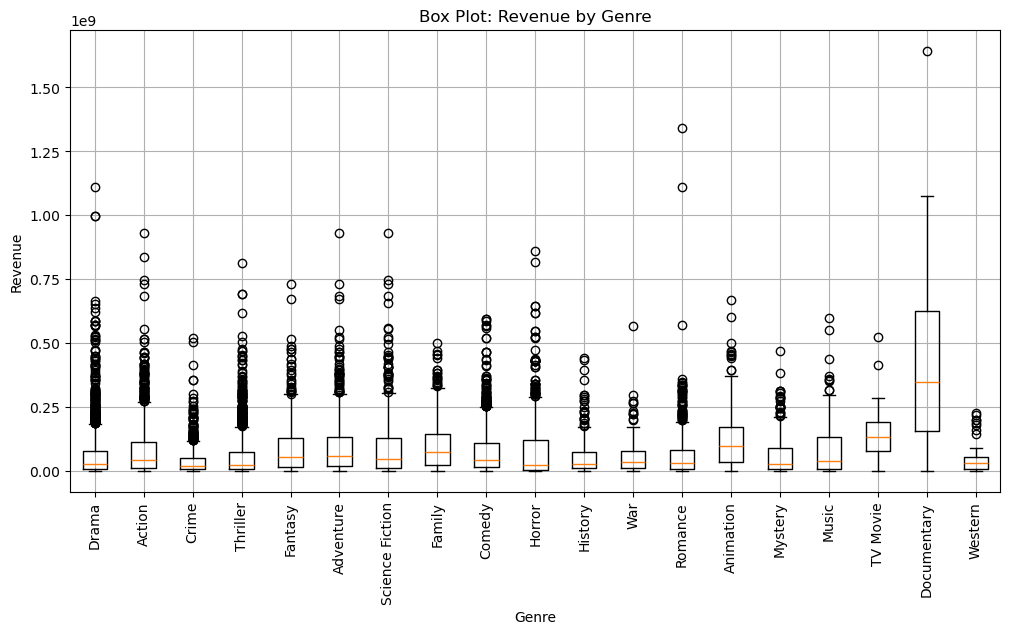

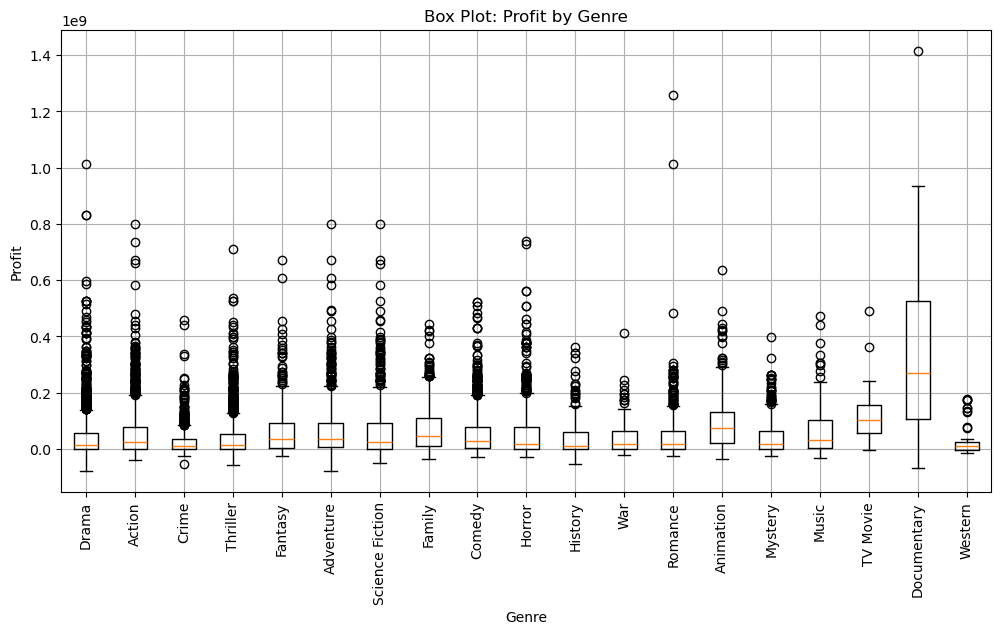

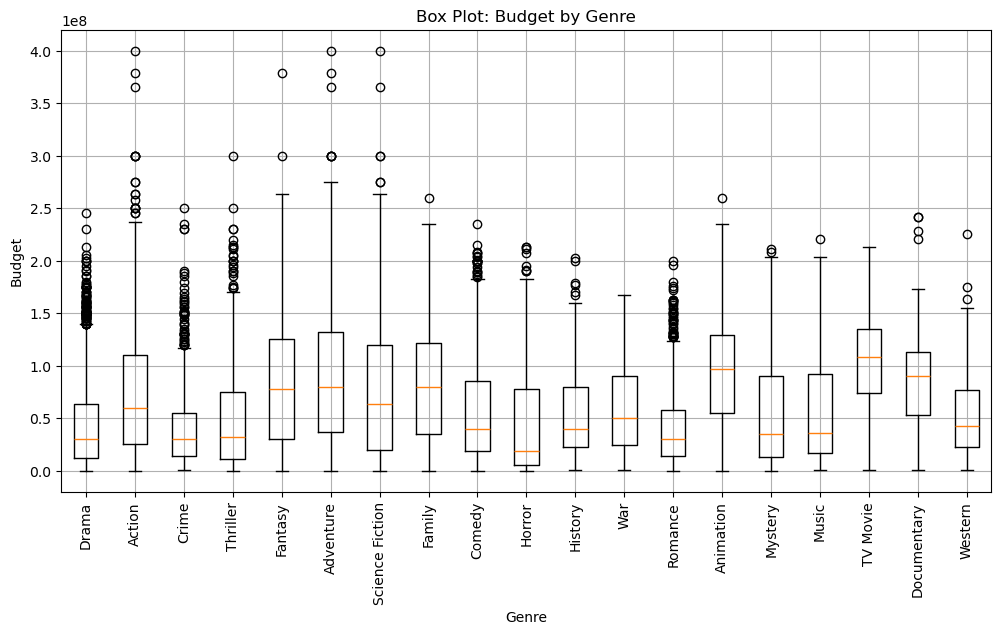

In [8]:
# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Revenue by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Revenue_mean'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.title('Box Plot: Revenue by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Profit by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Profit_mean'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Profit')
plt.title('Box Plot: Profit by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Set the figure size
plt.figure(figsize=(12, 6))

# Box plot for Budget by Genre
plt.boxplot([merged_data_df[merged_data_df['Genre'] == genre]['Budget'] for genre in merged_data_df['Genre'].unique()], labels=merged_data_df['Genre'].unique())
plt.xlabel('Genre')
plt.ylabel('Budget')
plt.title('Box Plot: Budget by Genre')
plt.xticks(rotation=90)  
plt.grid(True)
plt.show()

# Calculate statistics and outliers for revenue by genre

In [9]:
# Initialize dictionary to store outliers, mean, mode, median, and outlier count for each genre
genre_info = {}
genres = merged_data['Genre'].unique()
# Loop through each genre

# Initialize dictionary to store mean, mode, and median for each genre
Summary_Statistic = {}

for genre in genres:
    # Filter DataFrame for the current genre
    genre_data = merged_data[merged_data['Genre'] == genre]
    
    # Calculate quartiles and IQR for revenue
    quartiles = genre_data['Revenue_mean'].quantile([0.25, 0.5, 0.75])
    lower_q = quartiles[0.25]
    upper_q = quartiles[0.75]
    IQR = upper_q - lower_q
    
    # Calculate lower and upper bounds for outliers
    lower_bound = lower_q - 1.5 * IQR
    upper_bound = upper_q + 1.5 * IQR
    
    # Identify outliers for the current genre
    outliers = genre_data[(genre_data['Revenue_mean'] < lower_bound) | (genre_data['Revenue_mean'] > upper_bound)]
    
    # Store outliers and outlier count for the current genre in the dictionary
    Summary_Statistic[genre] = {
        'lower bound': lower_bound,
        'upper_bound': upper_bound,  
        'mean': genre_data['Revenue_mean'].mean(),
        'median': genre_data['Revenue_mean'].median(),
        'mode':genre_data['Revenue_mean'].mode().iloc[0], # Extract the first mode value
        'outliers': outliers['Revenue_mean'],
        'outlier_count': len(outliers)
    }


Summary_Statistic_Table = pd.DataFrame(Summary_Statistic)
Summary_Statistic_Table.head(10)

,Drama,Action,Crime,Thriller,Fantasy,Adventure,Science Fiction,Family,Comedy,Horror,History,War,Romance,Animation,Mystery,Music,TV Movie,Documentary,Western
lower bound,-100400426.833333,-143553573.1875,-61451320.583333,-96860816.770833,-158108216.546429,-150833693.5625,-168393852.372083,-158075049.825,-128466188.114583,-168953284.85,-90537625.25,-94060974.833333,-104379914.125,-170318244.81875,-116153669.0625,-174565152.675,-93340764.266667,-547258914.875,-59811186.25
upper_bound,184216685.166667,268218891.9125,117345888.083333,176196035.5625,298982112.910714,298803635.604167,307051099.23125,325813331.375,250951803.46875,291618830.75,173470647.416667,180015255.833333,194127286.875,377246736.864583,211121116.4375,312145986.458333,362443765.333333,1329781315.325,119602978.416667
mean,64266123.145545,80360939.719528,41717932.634173,58542266.958361,87077812.015682,91331947.468111,90436613.128152,93811564.419667,74836437.815099,78773908.299197,62216719.272335,62978281.889535,61459197.590667,114212241.875712,57521423.371363,83606510.438757,138044273.203222,394012183.282118,51427538.887647
median,23909456.5,39957127.75,19097117.75,22049829.666667,53678585.0,55296878.0,45859882.516667,72013183.625,43353491.0,22910563.0,25181895.0,32323764.333333,28220735.0,97726381.12,26256476.0,36987770.006667,131207673.088889,345336673.4,28252532.5
mode,583921229.0,2333333.333333,17313337.833333,286212543.0,22974634.0,87462584.0,337142.857143,212866272.8,62433107.333333,427304425.6,73070073.666667,800000.0,191768010.5,212866272.8,79127037.45,101.0,126.333333,716719914.2,26823.5
outliers,0 6.223136e+08 26 2.135915e+08 32...,12 7.309265e+08 25 6.827866e+08 73...,68 1.299387e+08 244 4.122346e+08 31...,87 1.902650e+08 137 2.555250e+08 24...,9 7.309265e+08 44 4.374773e+08 46...,10 7.309265e+08 23 6.827866e+08 45...,11 7.309265e+08 24 6.827866e+08 72...,77 341772756.7 332 468047426.0 468 ...,184 2.535776e+08 211 2.875726e+08 22...,403 4.282145e+08 1707 3.016358e+08 25...,132 4.327657e+08 1426 2.067002e+08 17...,554 2.736632e+08 4958 2.232405e+08 62...,33 3.139256e+08 134 1.111493e+09 43...,196 446900098.6 333 468047426.0 4940...,74 3.132066e+08 361 2.483919e+08 95...,977 4.363883e+08 5947 3.549657e+08 67...,3590 415107672.3 7081 523329666.0 Name: ...,"6308 1.644265e+09 Name: Revenue_mean, dtype...",1389 2.249208e+08 1630 1.776461e+08 27...
outlier_count,182,86,68,136,25,45,36,19,76,50,23,11,49,11,24,9,2,1,8


# Visual 1: Overview of Genres (Bar chart, pie chart) by sum/average(decide later) revenue & Genre by movie count

** Keep Revenue values as it is (No Division) _ Plot based on Mean

In [10]:
# Group the DataFrame by genre and calculate total revenue for each genre
genre_revenue = df_genre.groupby('Genre').agg({'Revenue': 'sum', 'Name': 'count'})
genre_revenue['Average_Revenue'] = genre_revenue['Revenue'] / genre_revenue['Name']
genre_revenue.reset_index(inplace=True)

# Three top Genres:
genre_revenue_sorted = genre_revenue.sort_values ("Revenue",ascending = False)
genre_revenue_sorted.head(5)

,Genre,Revenue,Name,Average_Revenue
0,Action,3.546686e+11,1436,2.469837e+08
3,Comedy,3.429143e+11,1666,2.058309e+08
1,Adventure,3.271453e+11,1015,3.223107e+08
6,Drama,2.823142e+11,1823,1.548624e+08
7,Family,2.805633e+11,886,3.166628e+08


In [11]:
# # Plotting the pie chart
# plt.figure(figsize=(10, 5))
# plt.pie(genre_revenue["Revenue"], labels=genre_revenue['Genre'], autopct='%1.1f%%')
# plt.legend(loc="upper right", bbox_to_anchor=(1.1, 1))
# plt.title('Revenue Distribution by Genre')
# plt.axis('equal')
# plt.show()

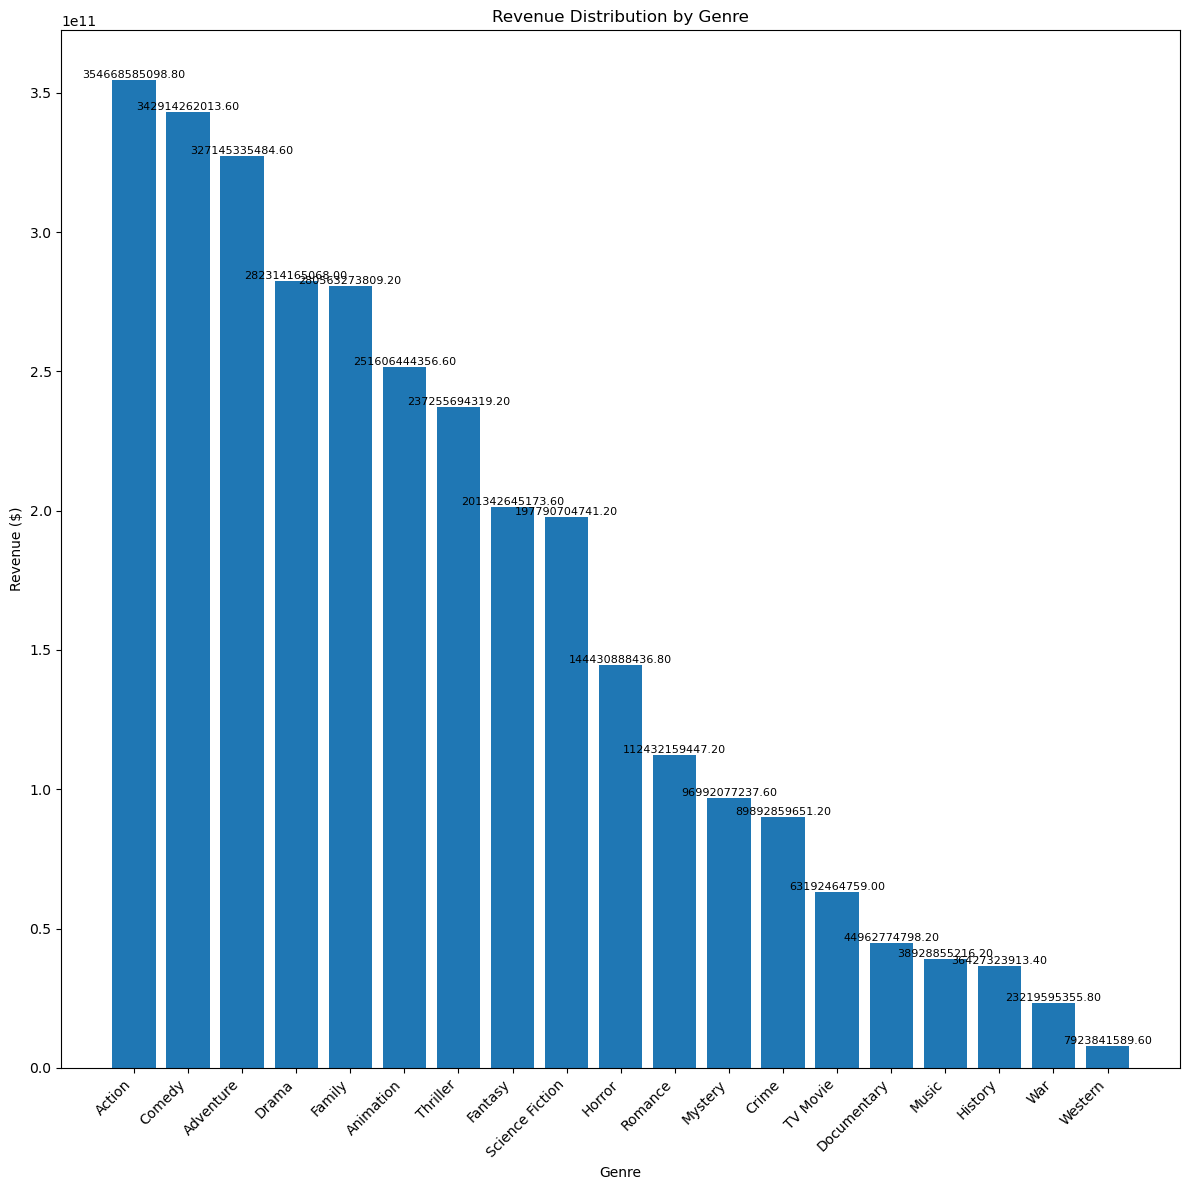

In [12]:
# Plotting the bar chart
plt.figure(figsize=(12, 12))
bars = plt.bar(genre_revenue_sorted['Genre'], genre_revenue_sorted["Revenue"], align="center")
plt.xticks(rotation=45, ha="right")
plt.xlabel('Genre')
plt.ylabel("Revenue ($)")
plt.title('Revenue Distribution by Genre')

#Annotate each bar with its value
plt.bar_label(bars, fmt='%.2f', label_type='edge', fontsize=8)
plt.tight_layout()

# Show the plot
plt.show()


** Keep Revenue values as it is (No Division) _ Plot based on Median

In [13]:
genre_revenue_median = df_genre.groupby("Genre").agg({'Revenue':'median'}).reset_index ()
genre_revenue_median_sorted = genre_revenue_median.sort_values ("Revenue", ascending = False)
genre_revenue_median_sorted.head(5)

,Genre,Revenue
15,TV Movie,470441838.0
5,Documentary,463712263.7
2,Animation,374450000.7
7,Family,261512011.5
1,Adventure,215080810.0


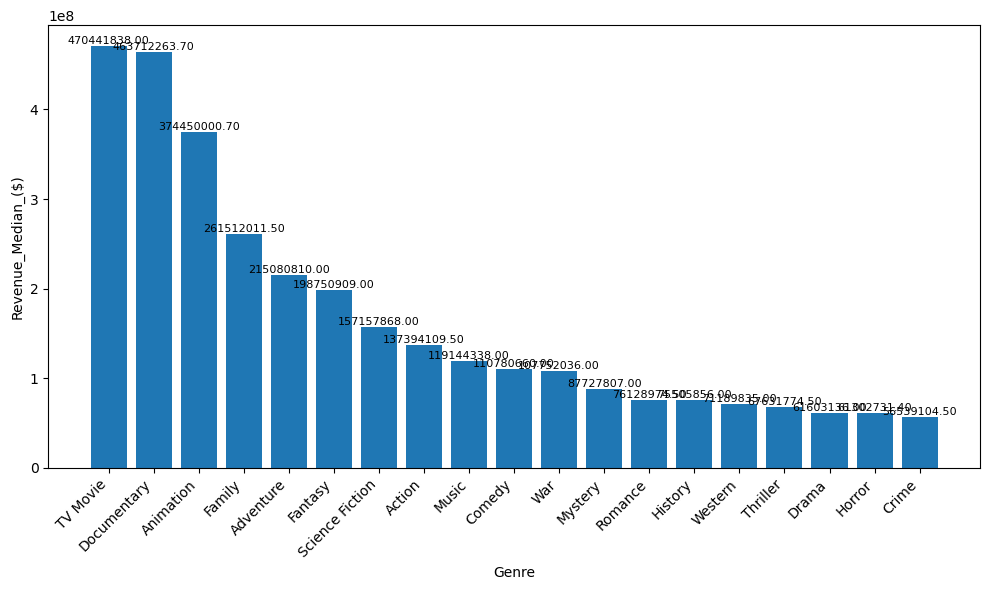

In [14]:
plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_median_sorted["Genre"],genre_revenue_median_sorted["Revenue"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Median_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge")
plt.show()


** Plot based on Revenue mean (Revenue/count of genres)_Average

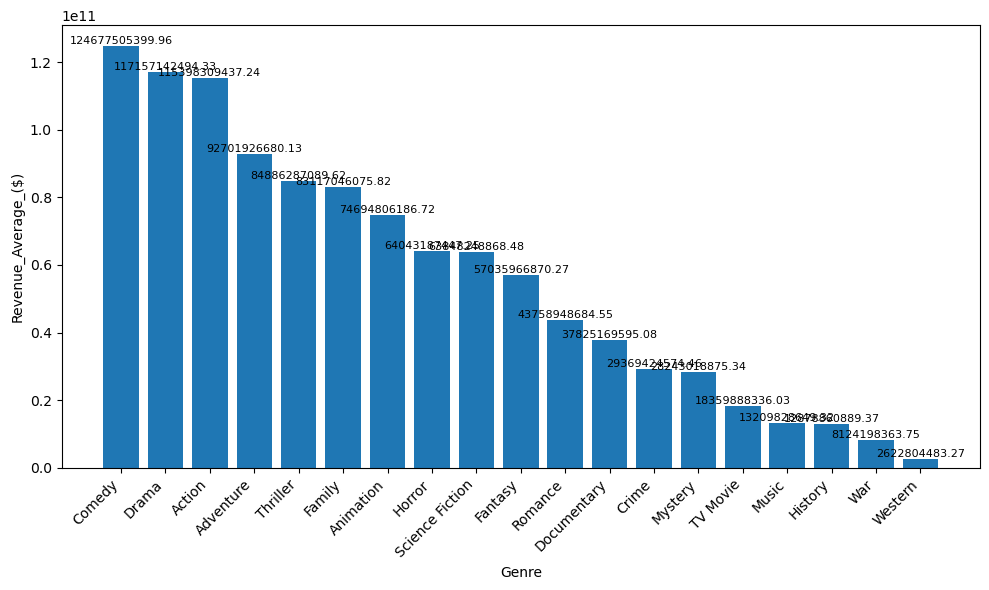

In [15]:
# genre_revenue = merged_data_df.groupby('Genre').agg({'Revenue_mean': 'mean'}).reset_index()
# genre_revenue.reset_index(inplace=True)

genre_revenue = merged_data_df.groupby('Genre').agg({'Revenue_mean': 'sum','Name':'count'})
genre_revenue['Average_Revenue'] = genre_revenue['Revenue_mean'] / genre_revenue['Name']
genre_revenue.reset_index(inplace=True)

# Three top Genres:
genre_revenue_sorted = genre_revenue.sort_values ("Revenue_mean",ascending = False)
genre_revenue_sorted.head(5)

plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_sorted["Genre"],genre_revenue_sorted["Revenue_mean"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Average_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge")
plt.show()

** Plot based on Revenue mean (Revenue/count of genres)_Median

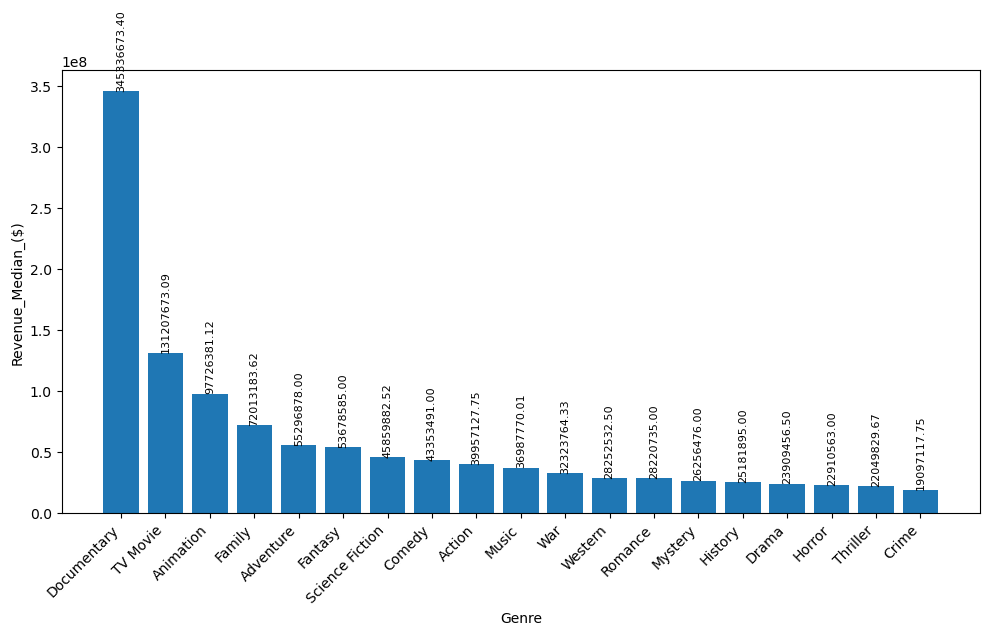

In [16]:
genre_revenue_median = merged_data_df.groupby("Genre").agg({'Revenue_mean':'median'}).reset_index ()
genre_revenue_median_sorted = genre_revenue_median.sort_values ("Revenue_mean", ascending = False)
genre_revenue_median_sorted.head(5)

plt.figure(figsize=(10,6))
bars = plt.bar(genre_revenue_median_sorted["Genre"],genre_revenue_median_sorted["Revenue_mean"],align = "center")
plt.xlabel("Genre")
plt.ylabel("Revenue_Median_($)")
plt.xticks(rotation=45, ha = "right")
plt.tight_layout()
plt.bar_label(bars, fontsize=8, fmt = "%.2f", label_type = "edge", rotation = 90)
plt.show()

# Visual 2: Breakdown by three decades

In [17]:
merged_data_df.head(5)

,Name,Year,Genre,Genre_count,Score,Budget,Revenue_mean,Profit_mean
0,the passion of the christ,2004,Drama,1,74.0,25000000.0,6.223136e+08,597313635.0
1,john wick: chapter 2,2017,Action,3,73.0,40000000.0,5.717996e+07,43846629.0
2,john wick: chapter 2,2017,Crime,3,73.0,40000000.0,5.717996e+07,43846629.0
3,john wick: chapter 2,2017,Thriller,3,73.0,40000000.0,5.717996e+07,43846629.0
4,john wick: chapter 3 - parabellum,2019,Action,3,74.0,55000000.0,1.089032e+08,90569909.0


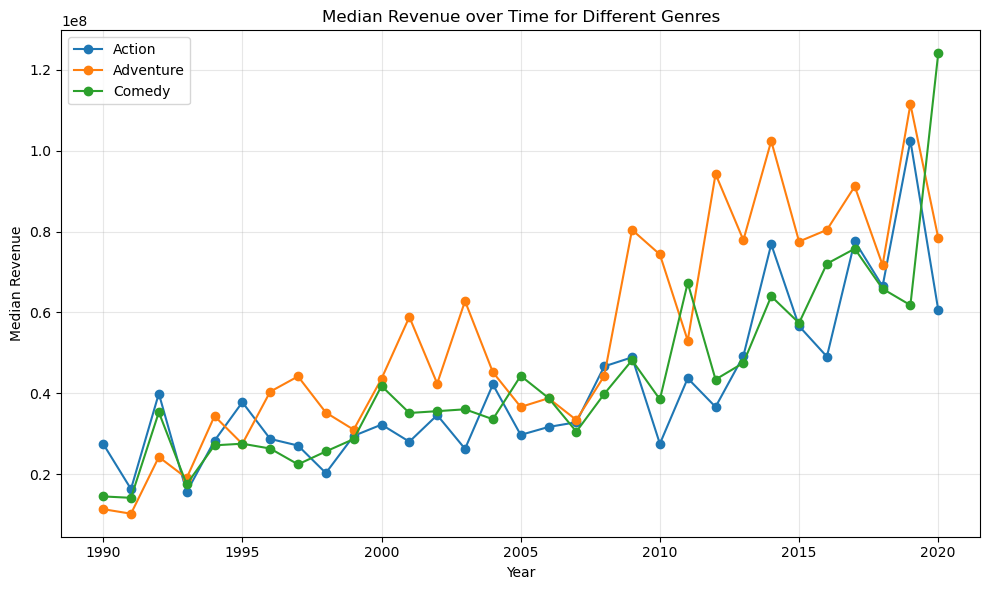

In [18]:
# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Iterate over each genre
for genre in genres:
    # Filter the DataFrame for the current genre
    df_genre_genre = merged_data_df[merged_data_df['Genre'] == genre]
    
    # Group by year and calculate the median revenue for each year
    df_median_revenue = df_genre_genre.groupby('Year')['Revenue_mean'].median().reset_index()
    
    # Plot median revenue for the current genre
    plt.plot(df_median_revenue['Year'], df_median_revenue['Revenue_mean'], marker='o', linestyle='-', label=genre)

# Add title and labels
plt.title('Median Revenue over Time for Different Genres')
plt.xlabel('Year')
plt.ylabel('Median Revenue')
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

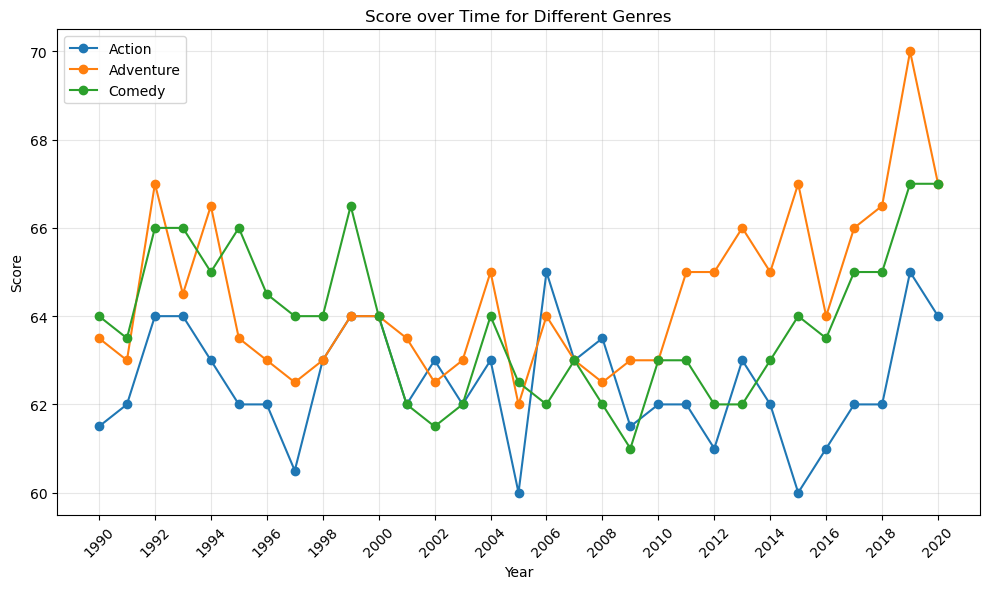

In [19]:
# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# Create a figure for the plot
plt.figure(figsize=(10, 6))

# Iterate over each genre
for genre in genres:
    # Filter the DataFrame for the current genre
    df_genre_genre = merged_data_df[merged_data_df['Genre'] == genre]
    
    # Group by year and calculate the median revenue for each year
    df_median_revenue = df_genre_genre.groupby('Year')['Score'].median().reset_index()
    
    # Plot median revenue for the current genre
    plt.plot(df_median_revenue['Year'], df_median_revenue['Score'], marker='o', linestyle='-', label=genre)

# Add title and labels
plt.title('Score over Time for Different Genres')
plt.xlabel('Year')
plt.ylabel('Score')
# Customize the xticks
plt.xticks(range(1990, 2021, 2), rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

# Disposable Personal Income Summary: Disposable Personal Income,Population, and Per Capita Disposable Personal Income
** DPI is amount of money that an individual or household has to spend or save after income taxes have been deducted

In [ ]:
# Filter for selected Genres
df_genre_copy = merged_data_df.copy()
df_genre_copy["Genre"] = df_genre_copy["Genre"].str.strip().str.lower()
selected_genres = ["action", "comedy", "adventure"]
df_genre_filtered = df_genre_copy[df_genre_copy["Genre"].isin(selected_genres)].copy()  # Explicitly create a copy
df_genre_filtered["Genre"] = df_genre_filtered["Genre"].str.capitalize()  # Capitalize genre names

Final_df_DPI = df_genre_filtered.groupby(["Genre", "Year"], observed=False)[["Profit_mean", "Revenue_mean", "Budget"]].median().reset_index()
Final_df_DPI.head(5)

In [ ]:
# Construct the API request URL
base_url = 'https://apps.bea.gov/api/data/'
endpoint = 'GetData'
dataset = 'REGIONAL'  # National Income and Product Accounts dataset
TableName = 'SAINC51'
frequency = 'A'  # Annual data
year_range = '2000'  # Desired time period (comma-delimited string)
geofips = '00000'  # National level data
LineCode = 'All'
parameters = {
    'UserID': api_key,
    'method': 'GetData',
    'datasetname': dataset,
    'TableName': TableName,
    'Frequency': frequency,
    'Year': year_range,
    'GeoFips': geofips,
    'LineCode': LineCode,
    'ResultFormat': 'JSON'  
}

# Send API request
response = requests.get(base_url, params=parameters).json()
print (json.dumps(response,indent=4,sort_keys=False))

In [ ]:
# Add new columns
Final_df_DPI['Disposable personal income (DPI)']=""
Final_df_DPI['DPI UNIT MULT']=""
Final_df_DPI['Population']=""
Final_df_DPI['Population UNIT MULT']=""
Final_df_DPI.head(5)

In [ ]:
# Set the API base URL
base_url = 'https://apps.bea.gov/api/data/'

params ={ 'UserID': api_key,
    'method': 'GetData',
    'datasetname': 'REGIONAL',
    'TableName': 'SAINC51',
    'Frequency': 'A',
    'GeoFips': '00000',
    'LineCode': 'All',
    'ResultFormat': 'JSON'  
}

for i, row in Final_df_DPI.iterrows():
    year = row ["Year"]
    params["Year"]=f"{year}"
    response = requests.get(base_url, params=params).json()
    
    try:
        response = requests.get(base_url, params=params).json()
        Final_df_DPI.loc[i, "Disposable personal income (DPI)"] = float(response["BEAAPI"]["Results"]["Data"][0]["DataValue"])
        Final_df_DPI.loc[i, "DPI UNIT MULT"] = float(response["BEAAPI"]["Results"]["Data"][0]["UNIT_MULT"])
        Final_df_DPI.loc[i, "Population"] = float(response["BEAAPI"]["Results"]["Data"][1]["DataValue"])
        Final_df_DPI.loc[i, "Population UNIT MULT"] = float(response["BEAAPI"]["Results"]["Data"][1]["UNIT_MULT"])
    # Broaden the exception handling to catch any exception
    except Exception as e: 
        # Print the error message
        print(f"Error processing {year}: {e.args[0]} not found")  
        Final_df_DPI.loc[i, ["Disposable personal income (DPI)", "DPI UNIT MULT", "Population", "Population UNIT MULT"]] = float("nan")
        pass

    
# Indicate that Data Loading is complete 
print("-----------------------------")
print("Data Retrieval Complete      ")
print("-----------------------------")
Final_df_DPI.head (15)

In [ ]:
Final_df_DPI["DPI UNIT MULT"].nunique()

In [ ]:
Final_df_DPI["Genre"].value_counts()

In [ ]:
Final_df_DPI.dtypes

In [ ]:
# Drop rows with NaN values if there is any
Final_df_DPI['Disposable personal income (DPI)'] = pd.to_numeric(Final_df_DPI['Disposable personal income (DPI)'], errors='coerce')
Final_df_DPI = Final_df_DPI.dropna()
Final_df_DPI.reset_index(drop=True, inplace=True)
Final_df_DPI.count()

In [ ]:
Final_df_DPI.dtypes

# Disposable personal income (DPI) vs Years 

In [ ]:
# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# Create a figure for the plot
plt.figure(figsize=(8, 5))

# Iterate over each genre
for genre in genres:
    # Filter the DataFrame for the current genre
    df_genre_genre = Final_df_DPI[Final_df_DPI['Genre'] == genre]    
    year = df_genre_genre["Year"]
    DPI = df_genre_genre["Disposable personal income (DPI)"]*(10**df_genre_genre["DPI UNIT MULT"])

    plt.plot(year, DPI, marker='o', linestyle='-', label=genre)

# Add title and labels
plt.title('Disposable personal income over Time for Different Genres')
plt.xlabel('Year')
plt.ylabel('Disposable personal income')
plt.legend()
plt.grid(True, alpha=0.3)

# Show plot
plt.tight_layout()
plt.show()

# disposable personal income vs Revenue gives - Correlation - for different Genres

In [ ]:
# Define the regression plot function
def regression_plot(x_values, y_values, genre):
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope, 2)) + "x + " + str(round(intercept, 2))
    plt.scatter(x_values, y_values)
    plt.plot(x_values, regress_values, "r-")
    plt.text(x_values.min(), y_values.min(), line_eq, fontsize=12, color="red")
    plt.xlabel('Revenue_mean')
    plt.ylabel('Disposable personal income (DPI)')
    plt.title(f"Regression: Revenue vs DPI for {genre}")
    plt.show()

# Define the correlation plot function
def correlation_plot(x_values, y_values, genre):
    correlation = st.pearsonr(x_values, y_values)
    print(f"Correlation for {genre}: {round(correlation[0], 2)}")

# Create a list of genres
genres = ['Action', 'Adventure', 'Comedy']

# Iterate over each genre
for genre in genres:
    # Filter DataFrame for the current genre
    df_genre = Final_df_DPI[Final_df_DPI['Genre'] == genre]    
    x_values = df_genre['Revenue_mean']
    y_values = df_genre['Disposable personal income (DPI)']
    
    # Plot regression and calculate correlation
    regression_plot(x_values, y_values, genre)
    correlation_plot(x_values, y_values, genre)